In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imp import reload

import pickle
import glob
import os
import feature_extractor
import search_classify
import config

import pickle

from scipy.ndimage.measurements import label


reload(feature_extractor)
reload(search_classify)
reload(config)

from feature_extractor import *
import search_classify
reload(search_classify)
from search_classify import *
from config import *

from enum import Enum

class ColorSpace(Enum):
    RGB = 'RGB'
    HSV = 'HSV'
    LUV = 'LUV'
    HSL = 'HSL'
    YUV = 'YUV'
    YCrCb = 'YCrCb'
    

def ReadImg(path):
    return mpimg.imread(path)

In [11]:
img_types = os.listdir('{}/vehicles/'.format(TEST))

cars = []
notcars = []

for img_type in img_types:
    cars.extend(glob.glob('{}/vehicles/{}/*.png'.format(TEST, img_type)))
    

img_types = os.listdir('{}/non-vehicles/'.format(TEST))
for img_type in img_types:
    notcars.extend(glob.glob('{}/non-vehicles/{}/*.png'.format(TEST, img_type)))
    
print('Non-vehicles found: ', len(notcars))
print('Vehicles found: ', len(cars))

Non-vehicles found:  8968
Vehicles found:  8792


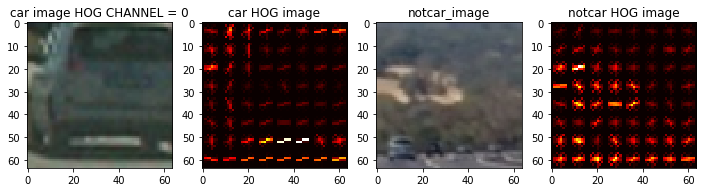

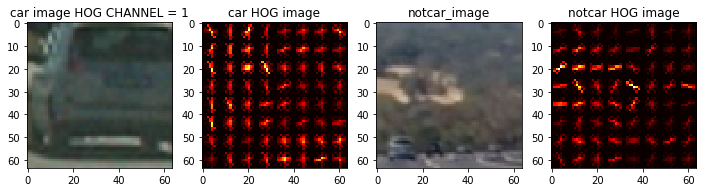

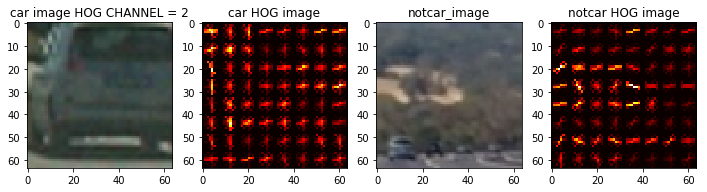

In [3]:
# Get car indices
car_idx = np.random.randint(0, len(cars))
notcar_idx = np.random.randint(0, len(notcars))

# Get images
car_img = ReadImg(cars[car_idx])
notcar_img = ReadImg(notcars[notcar_idx])


for hog_channel in [0, 1, 2]:
    car_features, car_hog_img = single_img_features(car_img, color_space=COLOR_SPACE, spatial_size=SPATIAL_SIZE,
                            hist_bins=HIST_BIN, orient=ORIENT, 
                            pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, hog_channel=hog_channel,
                            spatial_feat=SPATIAL_FEAT, hist_feat=HIST_FEAT, hog_feat=HOG_FEAT, vis=True)
    
    notcar_features, notcar_hog_img = single_img_features(notcar_img, color_space=COLOR_SPACE, spatial_size=SPATIAL_SIZE,
                            hist_bins=HIST_BIN, orient=ORIENT, 
                            pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, hog_channel=hog_channel,
                            spatial_feat=SPATIAL_FEAT, hist_feat=HIST_FEAT, hog_feat=HOG_FEAT, vis=True)

    images = [car_img, car_hog_img, notcar_img, notcar_hog_img]
    titles = ['car image HOG CHANNEL = {}'.format(hog_channel), 'car HOG image', 'notcar_image', 'notcar HOG image']
    fig = plt.figure(figsize=(12, 3))
    visualize(fig, 1, 4, images, titles)
    plt.show()

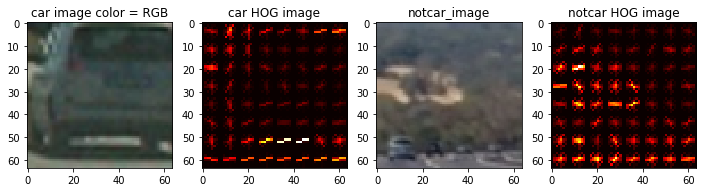

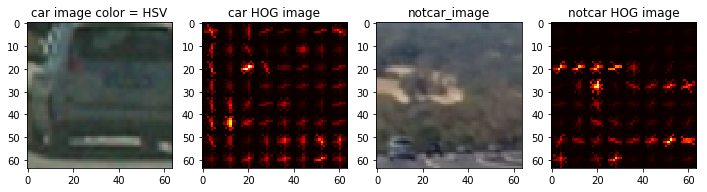

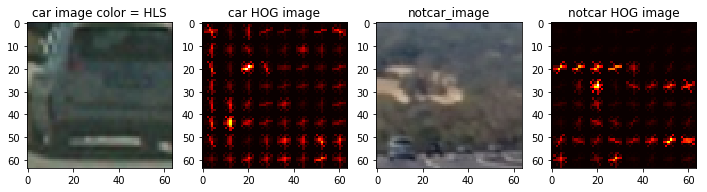

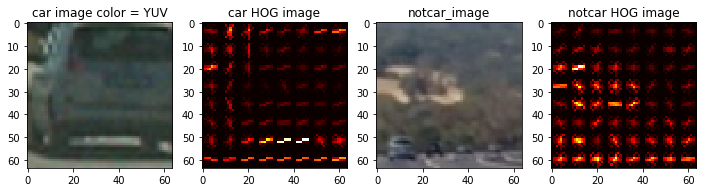

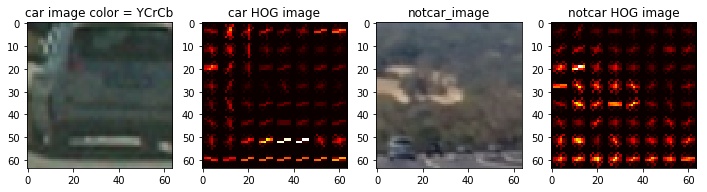

In [4]:
for color_space in ['RGB', 'HSV', 'HLS', 'YUV', 'YCrCb']:
    car_features, car_hog_img = single_img_features(car_img, color_space=color_space, spatial_size=SPATIAL_SIZE,
                            hist_bins=HIST_BIN, orient=ORIENT, 
                            pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, hog_channel=0,
                            spatial_feat=SPATIAL_FEAT, hist_feat=HIST_FEAT, hog_feat=HOG_FEAT, vis=True)

    notcar_features, notcar_hog_img = single_img_features(notcar_img, color_space=color_space, spatial_size=SPATIAL_SIZE,
                            hist_bins=HIST_BIN, orient=ORIENT, 
                            pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, hog_channel=0,
                            spatial_feat=SPATIAL_FEAT, hist_feat=HIST_FEAT, hog_feat=HOG_FEAT, vis=True)

    images = [car_img, car_hog_img, notcar_img, notcar_hog_img]
    titles = ['car image color = {}'.format(color_space), 'car HOG image', 'notcar_image', 'notcar HOG image']

    fig = plt.figure(figsize=(12, 3))
    visualize(fig, 1, 4, images, titles)
    plt.show()

In [9]:
car_features = extract_features(cars, color_space=COLOR_SPACE, spatial_size=SPATIAL_SIZE,
                        hist_bins=HIST_BIN, orient=ORIENT, 
                        pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, hog_channel=HOG_CHANNEL,
                        spatial_feat=SPATIAL_FEAT, hist_feat=HIST_FEAT, hog_feat=HOG_FEAT)

notcar_features = extract_features(notcars, color_space=COLOR_SPACE, spatial_size=SPATIAL_SIZE,
                        hist_bins=HIST_BIN, orient=ORIENT, 
                        pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, hog_channel=HOG_CHANNEL,
                        spatial_feat=SPATIAL_FEAT, hist_feat=HIST_FEAT, hog_feat=HOG_FEAT)

pickle.dump(car_features, open('{}/cars.p'.format(OUTPUT), 'wb'))
pickle.dump(notcar_features, open('{}/notcars.p'.format(OUTPUT), 'wb'))

print('car shapes {}'.format(len(car_features[0])))
print('not car shapes {}'.format(len(notcar_features[0])))

car shapes 8460
not car shapes 8460


### Training a LinearSVC

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler()
X_scaler.fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=.1, random_state=42)

svc = LinearSVC()
svc.fit(X_train, y_train)

print('TEST accuracy of svc = ', round(svc.score(X_test, y_test), 4))
pickle.dump(svc, open(SVC_MODEL, 'wb'))
pickle.dump(X_scaler, open(SCALER, 'wb'))

TEST accuracy of svc =  0.9921


## Sliding window

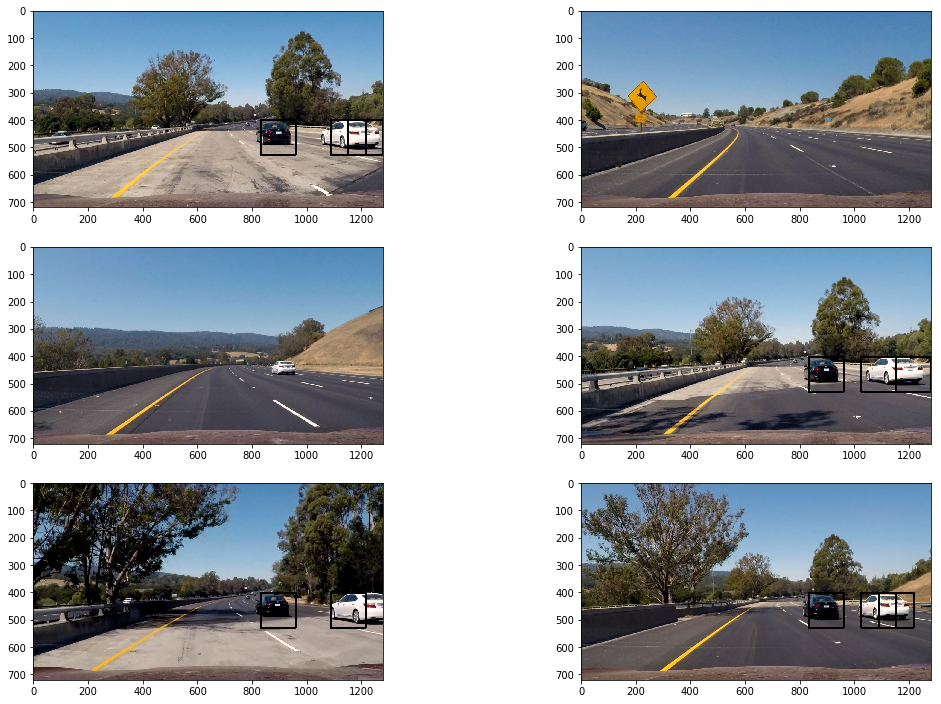

In [23]:
svc = pickle.load(open(SVC_MODEL, 'rb'))
X_scaler = pickle.load(open(SCALER, 'rb'))
images = []
titles = []
Y_START_STOP = [400, 656]
OVERLAP = 0.5
for file in glob.glob('{}/*.jpg'.format(TEST)):
    img = ReadImg(file)
    img = img.astype(np.float32)/255
    draw_img = np.copy(img)
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=Y_START_STOP, xy_window=(128, 128), xy_overlap=(OVERLAP, OVERLAP))
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=COLOR_SPACE, 
                    spatial_size=SPATIAL_SIZE, hist_bins=HIST_BIN, orient=ORIENT, 
                    pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, 
                    hog_channel=HOG_CHANNEL, spatial_feat=SPATIAL_FEAT, 
                    hist_feat=HIST_FEAT, hog_feat=HOG_FEAT)
    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    images.append(window_img)
    titles.append('')
fig = plt.figure(figsize=(18, 21))
visualize(fig, 5, 2, images, titles)
plt.show()

## Detecting false positive

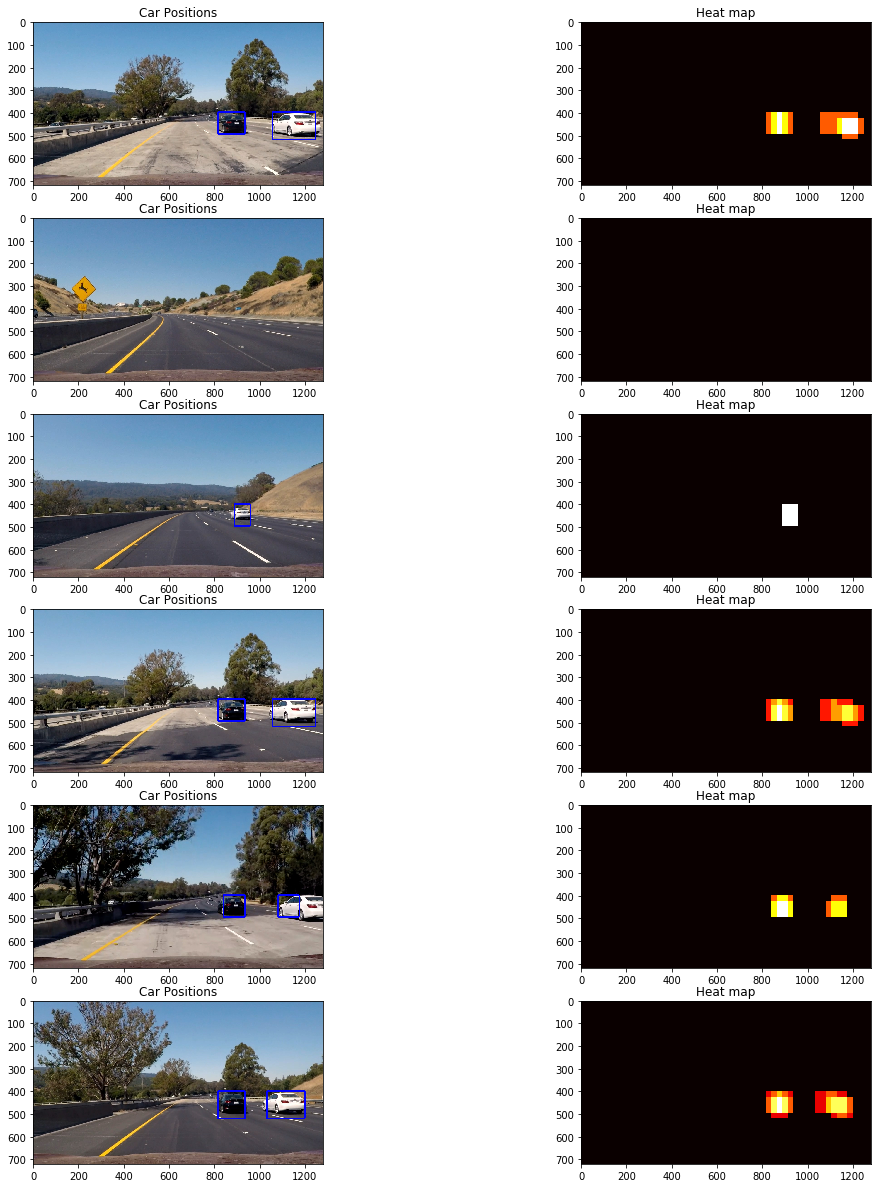

In [13]:
import search_classify
reload(search_classify)
from search_classify import *

heats = []
images = []
titles = []
Y_START_STOP = [400, 656]
SCALE = 1.5
for file in glob.glob('{}/*.jpg'.format(TEST)):
    img = ReadImg(file)
    draw_img, box_list = find_candidates(img, Y_START_STOP[0], Y_START_STOP[1], SCALE, svc, X_scaler, 
        ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, SPATIAL_SIZE, HIST_BIN)
    
    # Add heat to each box in box list
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

#     fig = plt.figure(figsize=(18,15))
#     plt.subplot(121)
#     plt.imshow(draw_img)
#     plt.title('Car Positions')
#     plt.subplot(122)
#     plt.imshow(heatmap, cmap='hot')
#     plt.title('Heat Map')
#     fig.tight_layout()
    images.append(draw_img)
    titles.append('Car Positions')
    images.append(heatmap)
    titles.append('Heat map')

#     images.append(draw_img)
#     titles.append('')
    
fig = plt.figure(figsize=(18, 21))
visualize(fig, 6, 2, images, titles)
plt.show()

In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def find_cars(img):
    draw_img, box_list = find_candidates(img, Y_START_STOP[0], Y_START_STOP[1], SCALE, svc, X_scaler,
        ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, SPATIAL_SIZE, HIST_BIN)

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [22]:
output_video = 'project_video.out.mp4'
input_video = 'project_video.mp4'

clip1 = VideoFileClip(input_video)
video_clip = clip1.fl_image(find_cars)
video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video project_video.out.mp4
[MoviePy] Writing video project_video.out.mp4


100%|█████████▉| 1260/1261 [07:53<00:00,  2.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video.out.mp4 



In [21]:
output_video = 'test_video.out.mp4'
input_video = 'test_video.mp4'

clip1 = VideoFileClip(input_video)
video_clip = clip1.fl_image(find_cars)
video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video test_video.out.mp4
[MoviePy] Writing video test_video.out.mp4


 97%|█████████▋| 38/39 [00:13<00:00,  2.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video.out.mp4 

